## 1. Imports

In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt

import pandas
from scipy import signal
from datetime import timedelta
from sklearn import svm
from sklearn.preprocessing import minmax_scale


## 2. Train set

In [27]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from build_model import train_dataset
   
dataset = train_dataset(path_prefix = '..')
dataset = dataset.loc[dataset['class'].isin([2, 3])]
dataset['is_flight'] = (dataset['class'] == 2).astype('float')

features = ['h_speed', 'v_speed']

dataset[features] = minmax_scale(dataset[features])

X_train = dataset[features]
y_train = dataset['is_flight']

## 3. Model parameters tuning

In [36]:
from sklearn.model_selection import GridSearchCV

kf = KFold(n_splits=5)

tuned_parameters = [{
    'kernel': ['rbf'],
    'gamma': [1.0, 0.1, 0.001, 0.0001, 0.00001],
    'C': [0.1, 1, 10, 100, 1000]
}]
                    

print("# Tuning hyper-parameters for accuracy")

clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=kf,
                   scoring='accuracy')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()   

# Tuning hyper-parameters for recall
Best parameters set found on development set:

{'C': 100, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on development set:

0.955 (+/-0.066) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.928 (+/-0.131) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.613 (+/-0.266) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.613 (+/-0.266) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.613 (+/-0.266) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.954 (+/-0.068) for {'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}
0.955 (+/-0.066) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.650 (+/-0.294) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.613 (+/-0.266) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.613 (+/-0.266) for {'C': 1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.960 (+/-0.069) for {'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}
0.954 (+/-0.068) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.928 (+/-0.131) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.650 (+/-0.294) f

## 4. Classifier training

In [28]:
svm_clf = svm.SVC(kernel='rbf', gamma=0.1, C=1000)
svm_clf.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## 5. Classifier testing

FLIGHT START: 2016-10-23 21:07:59.650000
AVG Speed before jump:  40.3418875395
FLIGHT END: 2016-10-23 21:09:54.200000


<IPython.core.display.Javascript object>


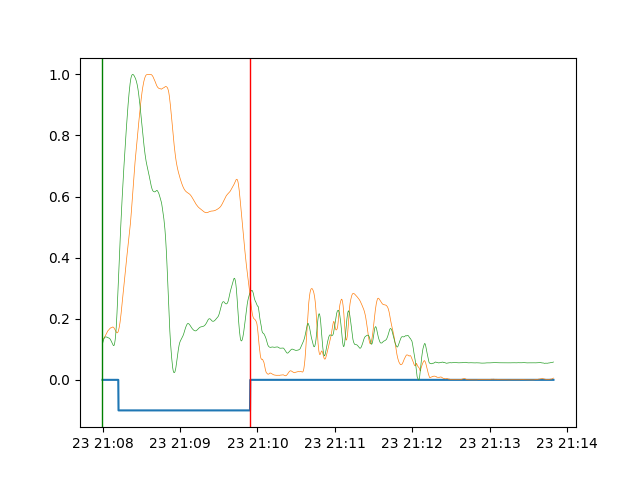

FLIGHT START: 2017-06-17 17:39:13.250000
AVG Speed before jump:  59.2946930797
FLIGHT END: 2017-06-17 17:41:16.600000


<IPython.core.display.Javascript object>


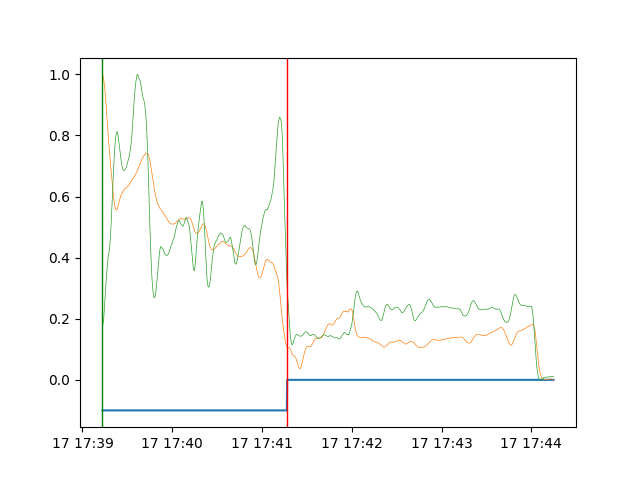

FLIGHT START: 2018-01-10 09:09:12.650000
AVG Speed before jump:  0.142908113218
FLIGHT END: 2018-01-10 09:09:55.400000


<IPython.core.display.Javascript object>


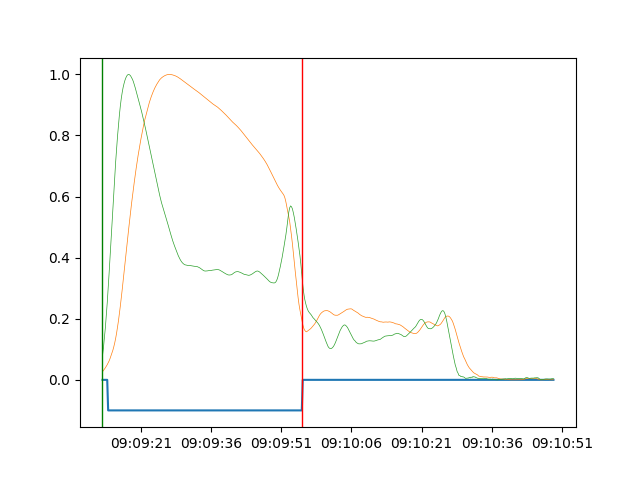

FLIGHT START: 2014-08-07 14:50:14.450000
AVG Speed before jump:  59.7352453567
FLIGHT END: 2014-08-07 14:52:02.800000


<IPython.core.display.Javascript object>


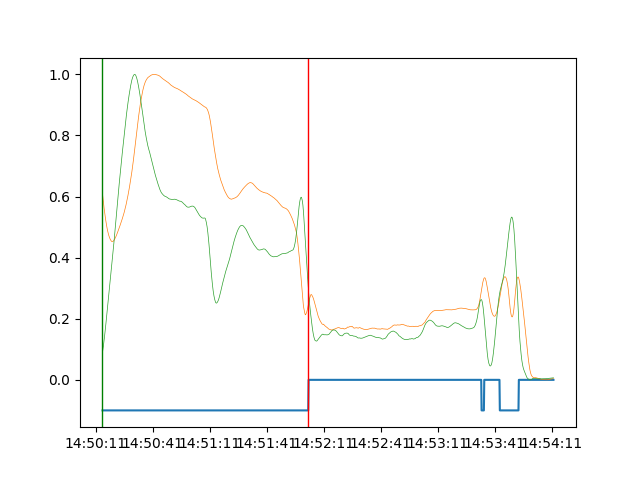

In [66]:
def predict_and_show(filename):
    df = pandas.read_csv('../data/test/' + filename)
    df['time'] = pandas.to_datetime(df['time'])
    df['prev_time'] = df.shift()['time']
    df['time_diff'] = df['time'] - df['prev_time']

    most_used_freq = df['time_diff'].value_counts().index.values[0]
    freq = 1000 / most_used_freq.astype('timedelta64[ms]').astype('float')
    window_size = freq * 3

    df.set_index('time', inplace=True)

    df['h_speed'] = (df['velN']**2 + df['velE']**2) ** 0.5
    df['v_speed'] = df['velD']
    df['h_speed'] = signal.savgol_filter(df['h_speed'], window_size, 0, mode='nearest')
    df['v_speed'] = signal.savgol_filter(df['v_speed'], window_size, 0, mode='nearest')

    V_SPEED_THRESHOLD = 7 # m/s
    df['flight_started'] = df['v_speed'].rolling(window='3s').mean().apply(lambda x: x > V_SPEED_THRESHOLD) 

    flight_start = df['flight_started'].ne(False).idxmax() - timedelta(seconds=2.55)
    print('FLIGHT START:', flight_start)


    print('AVG Speed before jump: ', df[:flight_start]['h_speed'].mean())
    
    df = df[flight_start:]
    df[features] = minmax_scale(df[features])
    
    X_test = df[features]
    
    df['predicted_svm'] = svm_clf.predict(X_test)
    
    
    df['group'] = df['predicted_svm'].diff().ne(0).cumsum()
    
    def group_details(x):
        return pandas.Series({
            'class': x.iloc[1].predicted_svm, 
            'size': len(x.index),
            'segment_end': x.index[-1]
        })
        
    segments = df.groupby('group').apply(group_details)
    idx = segments[segments['class'] == 1.0]['size'].idxmax()
    flight_end = segments.loc[idx].segment_end
    
    #flight_end = df['predicted_svm'].eq(1).cumsum().idxmax()
    print('FLIGHT END:', flight_end)
    
    plt.figure()
    plt.plot(df['predicted_svm'] * -0.1)
    plt.plot(X_test['h_speed'], linewidth=0.5)
    plt.plot(X_test['v_speed'], linewidth=0.5)
    plt.axvline(x=flight_start, color='green', linewidth=1)
    
    plt.axvline(x=flight_end, color='red', linewidth=1)


predict_and_show('#7990 15-56-18.CSV')
predict_and_show('Skydive Med WS 2 labeled.csv')
predict_and_show('Base Big WS labeled.csv')

predict_and_show('#703 14-41-39.CSV')
#predict_and_show('Skydive Med WS 2 labeled.csv')
#predict_and_show('Base Big WS labeled.csv')


plt.show()

## 6. Model visualization

<IPython.core.display.Javascript object>


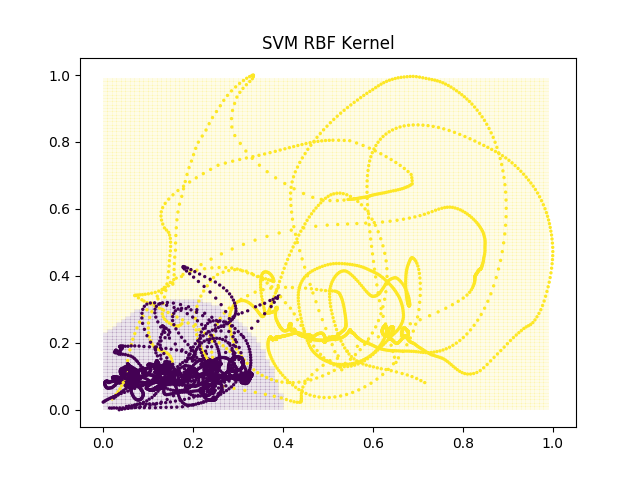

In [29]:
import numpy as np

plt.figure()
plt.scatter(X_train['h_speed'], X_train['v_speed'], c=dataset['is_flight'], zorder=10, s=2)

x_min, x_max = X_train['h_speed'].min(), X_train['h_speed'].max()
y_min, y_max = X_train['v_speed'].min(), X_train['v_speed'].max()

h = 0.01
XX, YY = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


Z = svm_clf.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
ax = plt.gca()
ax.pcolormesh(XX, YY, Z, alpha = 0.1)

plt.title('SVM RBF Kernel')

plt.show()